In [34]:
import pickle
import random
import warnings

import dill
import gpytorch
import torch
from botorch.exceptions import BotorchWarning
from botorch.models import SingleTaskGP

import IBBKernel
import matplotlib.pyplot as plt
import numpy as np

from gen_sim import combine_sos

torch.set_default_device('cuda')
torch.set_default_dtype(torch.double)

In [50]:
def warped_posterior_plot(warper, model, x_data, y_data, num_steps=80, scatter=True): 
    fig = plt.figure(figsize=(12, 6))
    grid_x, grid_y = torch.meshgrid(torch.linspace(0, 500, num_steps), torch.linspace(0, 200, num_steps), indexing='ij')
    grid_x= grid_x.cuda()
    grid_y = grid_y.cuda()
    valid_grid =  ((grid_x - warper['h']) ** 2 / warper['a'] + warper['k'] >= grid_y)
    vgx = grid_x[valid_grid]
    vgy = grid_y[valid_grid]
    values = warp(warper, torch.stack((vgx, vgy), dim=1))
    post = model.posterior(values)
    mu = post.mean.detach().cpu().numpy()
    var = post.variance.detach().cpu().numpy()
    mu_full = np.full((num_steps, num_steps), np.nan)
    var_full = np.full((num_steps, num_steps), np.nan)
    grid_x = grid_x.detach().cpu().numpy()
    grid_y = grid_y.detach().cpu().numpy()
    mu_full[np.nonzero(valid_grid.detach().cpu().numpy())] = mu.squeeze()
    var_full[np.nonzero(valid_grid.detach().cpu().numpy())] = var.squeeze()
    ax = fig.add_subplot(121)
    CS = ax.contourf(grid_x, grid_y, mu_full, 20, cmap='RdBu_r', vmin=-np.nanmax(abs(mu_full)), vmax=np.nanmax(abs(mu_full)))
    if scatter:
        ax.scatter(x_data[:, 0].cpu(), x_data[:, 1].cpu(), c=y_data.cpu(),
                       edgecolors='k', cmap='RdBu_r', vmin=-np.nanmax(abs(mu_full)), vmax=np.nanmax(abs(mu_full)))
    cbar = plt.colorbar(CS, ax=ax)
    plt.plot(np.linspace(0, 500, 100), (np.linspace(0, 500, 100) - warper['h']) ** 2 / warper['a'] + warper['k'])
    plt.ylim([0, 200])
    plt.ylabel('Pulse Width ($\\mu$s)')
    plt.xlabel('Amplitude ($\\mu$A)')
    cbar.set_label('RT (s)')
    
    ax2 = fig.add_subplot(122)
    CS2 = ax2.contourf(grid_x, grid_y, var_full, 20)
    cbar2 = plt.colorbar(CS2, ax=ax2)
    plt.plot(np.linspace(0, 500, 100), (np.linspace(0, 500, 100) - warper['h']) ** 2 / warper['a'] + warper['k'])
    plt.ylim([0, 200])
    plt.ylabel('Pulse Width ($\\mu$s)')
    plt.xlabel('Amplitude ($\\mu$A)')
    cbar2.set_label('Variance')

In [16]:
warnings.simplefilter("ignore", BotorchWarning)

xs = torch.rand((2000), device='cuda')
ys = torch.rand((2000), device='cuda')
test_data = torch.cos(2*torch.pi*xs) + torch.cos(torch.pi*ys)
test_data += torch.randn(test_data.shape, device='cuda')
train_x = torch.stack((xs,ys), dim=1)

covar_module = gpytorch.kernels.ScaleKernel(IBBKernel.IBBKernel(50, 20))
covar_module.outputscale = 0.001
model = SingleTaskGP(train_x, test_data.unsqueeze(-1), torch.ones_like(test_data).unsqueeze(-1), covar_module=covar_module)

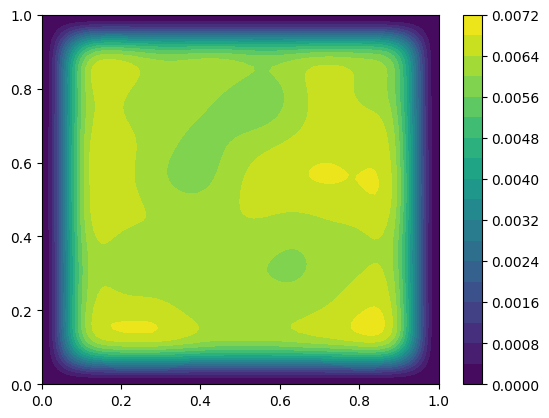

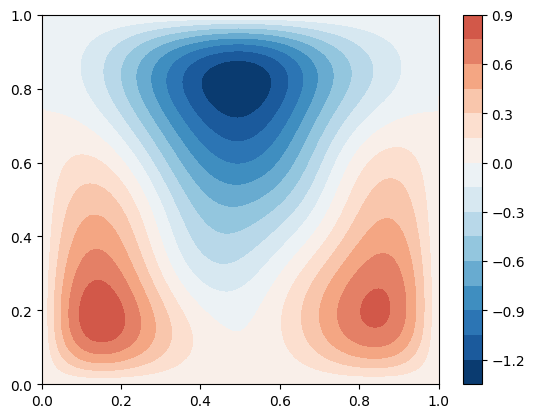

In [20]:
num_steps = 100
std = False
grid_x, grid_y = np.meshgrid(np.linspace(0, 1, num_steps), np.linspace(0, 1, num_steps), indexing='ij')
values = np.concatenate([grid_x.reshape(-1, 1), grid_y.reshape(-1, 1)], axis=1)
post = model.posterior(torch.tensor(values, device='cuda', dtype=torch.double),
                         observation_noise=False)
var = post.variance.detach().cpu().numpy()
fig = plt.figure()
ax = fig.add_subplot()
CS = plt.contourf(grid_x, grid_y, var.reshape((num_steps, num_steps)), 20)
cbar = plt.colorbar(CS, ax=ax)
fig2 = plt.figure()
ax2 = fig2.add_subplot()
mu = post.mean.detach().cpu().numpy()
CS2 = plt.contourf(grid_x, grid_y, mu.reshape((num_steps, num_steps)), 20, cmap='RdBu_r', vmin=-np.max(abs(mu)), vmax=np.max(abs(mu)))
cbar2 = plt.colorbar(CS2, ax=ax2)

In [23]:
def get_sample(sim, params, param_range):
    return (combine_sos(sim, params, param_range) / sim['scale'] * sim['mean_effect'] + np.random.normal(0, sim['std_effect'])) / sim['std_effect']

In [24]:
param_range = {'amp': (0, 500), 'pw': (0, 200)}

In [30]:
def warp(warper, input_data):
    x = input_data[:, 0]
    y = input_data[:, 1]

    if warper['h'] is None:
        return normalize(torch.stack((x, y), dim=1), warper['tensor_bounds'])

    x_2 = (200 - y) / warper['m'] + x  # Intersection of lines with upper boundary

    # Intersection of warp line through each point with safety bound
    x_1 = (-math.sqrt(warper['a']) * torch.sqrt(warper['a'] * warper['m'] ** 2 + 4 * warper['h'] * warper['m'] - 4 * warper['k'] - 4 * warper['m'] * x + 4 * y) + warper['a'] * warper['m'] + 2 * warper['h']) / 2
    y_1 = (x_1 - warper['h']) ** 2 / warper['a'] + warper['k']

    Do = torch.sqrt((y - y_1) ** 2 + (x - x_1) ** 2)  # Distance from each point to safety bound
    D = torch.sqrt((200 - y_1) ** 2 + (x_2 - x_1) ** 2)  # Distance to boundary for points to left of x_o

    y_2 = warper['m'] * (500 - x) + y  # Intersection of lines with right boundary
    D2 = torch.sqrt((y_2 - y_1) ** 2 + (500 - x_1) ** 2)  # Distance to boundary for points to right of x_o

    Ds = D
    Ds[x_1 > warper['x_o']] = D2[x_1 > warper['x_o']]

    y_2p = -warper['m'] * x + y  # Intersection of lines with left boundary
    x_2p = -y / warper['m'] + x  # Intersection of lines with lower boundary

    Dp = torch.sqrt((y_2p - y_1) ** 2 + x_1 ** 2)  # Distance from left boundary to safety bound along warp line
    Dp2 = torch.sqrt(y_1 ** 2 + (x_2p - x_1) ** 2)  # Distance from lower boundary to safety bound along warp line

    Dps = Dp
    Dps[x_2p > 0] = Dp2[x_2p > 0]

    dwarp = Ds * (Dps - Do) / Dps
    dwarp[x_1 < warper['h'] - math.sqrt(warper['a'] * (200 - warper['k']))] = 0
    dwarp[x_1 > 500] = 0

    return normalize(torch.stack((x + dwarp / math.sqrt(warper['m'] ** 2 + 1), y + dwarp * warper['m'] / math.sqrt(warper['m'] ** 2 + 1)), dim=1), warper['tensor_bounds'])

In [26]:
def unwarp(warper, input_data):
    raw_data = unnormalize(input_data, warper['tensor_bounds'])
    x = raw_data[:, 0].detach().cpu().numpy()
    y = raw_data[:, 1].detach().cpu().numpy()

    if warper['h'] is None:
        return np.stack((x, y), axis=1)

    uw = np.zeros((x.shape[0], 2))

    for i in range(uw.shape[0]):
        x_o = sympy.Symbol('x_o')
        y_o = sympy.Symbol('y_o')

        # Intersection of warp line through each point with safety bound
        try:
            x_1 = (-math.sqrt(warper['a']) * math.sqrt(
                warper['a'] * warper['m'] ** 2 + 4 * warper['h'] * warper['m'] - 4 * warper['k'] - 4 * warper['m'] * x[i] + 4 * y[i]) + warper['a'] * warper['m'] + 2 * warper['h']) / 2
            y_1 = (x_1 - warper['h']) ** 2 / warper['a'] + warper['k']
            if y_1 > 200 or x_1 > 500:
                uw[i, 0] = x[i]
                uw[i, 1] = y[i]
            else:
                x_2 = (200 - y[i]) / warper['m'] + x[i]  # Intersection of lines with upper boundary
                y_2 = warper['m'] * (500 - x[i]) + y[i]  # Intersection of lines with right boundary

                Do = sympy.sqrt((y_o - y_1) ** 2 + (x_o - x_1) ** 2)

                if x_1 > warper['x_o']:
                    Ds = math.sqrt((y_2 - y_1) ** 2 + (500 - x_1) ** 2)
                else:
                    Ds = math.sqrt((200 - y_1) ** 2 + (x_2 - x_1) ** 2)

                y_2p = -warper['m'] * x[i] + y[i]  # Intersection of lines with left boundary
                x_2p = -y[i] / warper['m'] + x[i]  # Intersection of lines with lower boundary

                if x_2p > 0:
                    Dps = math.sqrt(y_1 ** 2 + (x_2p - x_1) ** 2)
                else:
                    Dps = math.sqrt((y_2p - y_1) ** 2 + x_1 ** 2)

                w = Ds * (Dps - Do) / Dps
                expr1 = y_o + w * warper['m'] / sympy.sqrt(warper['m'] ** 2 + 1) - y[i]
                expr2 = x_o + w / sympy.sqrt(warper['m'] ** 2 + 1) - x[i]

                res = sympy.nsolve([expr1.simplify(), expr2.simplify()], [x_o, y_o], [250, 100])

                uw[i, 0] = float(res[0])
                uw[i, 1] = float(res[1])
        except ValueError:
            uw[i, 0] = x[i]
            uw[i, 1] = y[i]
    return uw

In [56]:
import sympy
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
import math
import copy
from botorch.exceptions import BotorchWarning
import warnings
from botorch.utils.transforms import unnormalize, normalize
from botorch.optim import optimize_acqf
from botorch.acquisition import UpperConfidenceBound, qLowerBoundMaxValueEntropy, PosteriorStandardDeviation

warnings.simplefilter("ignore", BotorchWarning)

with open('sims_100_01-06.pickle', 'rb') as handle:
    sims = pickle.load(handle)

tkwargs = {"dtype": torch.double, "device": 'cuda'}
bounds = [(0, 0), (500, 200)]
tensor_bounds = torch.atleast_2d(torch.tensor(bounds, **tkwargs))
init_params = [[0, 150, 300, 300, 150, 0], [0, 0, 0, 50, 50, 50]]
standard_bounds = torch.zeros(2, 2, **tkwargs)
standard_bounds[1] = 1

n_session = 8
n_trial = 150

aq_name = 'std'

class EGProblem(Problem):
    def __init__(self, model, sim):
        super().__init__(n_var=2, n_obj=2, n_ieq_constr=1, xl=[0,0], xu=[1,1])
        self.model = model
        self.sim = sim
    
    def _evaluate(self, x, out, *args, **kwargs):
        t_x = torch.tensor(x)
        mu = self.model.posterior(t_x).mean
        var = self.model.posterior(t_x).variance
        out['F'] = torch.cat((mu, -var), dim=1).detach().cpu().numpy()
        out['G'] = x[:, 1] * 200 - ((x[:, 0] * 500 - self.sim['saf_h']) ** 2 / self.sim['saf_a'] + self.sim['saf_k'])

algorithm = NSGA2(pop_size=60)

results = []
# Iterate over simulations
for n, sim in enumerate(sims):
    results.append({})
    # results[-1]['hyperparams'] = []
    
    # Generate safety condition
    warper = {'h': sim['saf_h'], 'a': sim['saf_a'], 'k': sim['saf_k'], 'tensor_bounds': tensor_bounds}

    m = sympy.Symbol('m', real=True)
    x = sympy.Symbol('x')
    y = sympy.Symbol('y')
    a = sympy.Symbol('a')
    h = sympy.Symbol('h')
    k = sympy.Symbol('k')

    res = sympy.solve([(x - h) ** 2 / a + k - y, sympy.exp(m) * (x - 500) - y + 200], [x, y], dict=True)
    x_o = res[0][x]
    if sim['saf_h'] - math.sqrt(sim['saf_a'] * (200 - sim['saf_k'])) < 0:
        x_1 = 0
    else:
        x_1 = h - sympy.sqrt(a * (200 - k))
    y_1 = (500 - h) ** 2 / a + k
    y = (x - h) ** 2 / a + k

    D1I = sympy.integrate(sympy.sqrt(1 + y ** 2), (x, x_1, x_o))
    D2I = sympy.integrate(sympy.sqrt(1 + y ** 2), (x, x_o, 500))

    expr = D1I / D2I - (500 - x_1) / (200 - y_1) * 2 / 5
    expr = expr.subs([(a, sim['saf_a']), (k, sim['saf_k']), (h, sim['saf_h'])])
    res2 = float(sympy.nsolve(expr, m, (-5, 5), solver='bisect'))
    warper['x_o'] = float(x_o.subs([(m, res2), (a, sim['saf_a']), (k, sim['saf_k']), (h, sim['saf_h'])]))
    warper['m'] = math.exp(res2)
    
    # Generate samples for initialization parameters
    params = copy.deepcopy(init_params)
    samples = []
    for i in range(len(init_params[0])):
        samples.append(get_sample(sim, {'amp': init_params[0][i], 'pw': init_params[1][i]}, param_range))
    x_data = torch.tensor(init_params, **tkwargs).transpose(0, 1)
    y_data = torch.unsqueeze(torch.tensor(samples, **tkwargs), dim=-1)
    warped_x_data = warp(warper, x_data)
    
    # Fit the GP model
    covar_module = gpytorch.kernels.ScaleKernel(IBBKernel.IBBKernel(50, 20))
    covar_module.outputscale = 0.001
    covar_module.raw_outputscale.requires_grad = False
    results[-1]['model'] = SingleTaskGP(warped_x_data, y_data, torch.ones_like(y_data), covar_module=covar_module)
    results[-1]['model'].mean_module.initialize(constant=0)
    results[-1]['model'].mean_module.raw_constant.requires_grad = False
    # mll = ExactMarginalLogLikelihood(results[-1]['model'].likelihood, results[-1]['model'])
    # fit_gpytorch_mll(mll)
    # results[-1]['hyperparams'].append(copy.deepcopy(results[-1]['model'].state_dict()))
    
    # Run n_session sessions of n_trial trials
    for i in range(n_trial * n_session):
        if aq_name != 'eg':
            if aq_name == 'gibbon':
                candidate_set = torch.rand(100, tensor_bounds.size(1), **tkwargs)
                acq_func = qLowerBoundMaxValueEntropy(results[-1]['model'], candidate_set, maximize=False)
            elif aq_name == 'ucb':
                d = 0.01
                t = len(init_params[0]) + i
                beta = 2 * np.log(t ** 3 * math.pi ** 2 / (3 * d))
                acq_func = UpperConfidenceBound(results[-1]['model'], beta=beta, maximize=False)
            elif aq_name == 'std':
                acq_func = PosteriorStandardDeviation(results[-1]['model'])
            
            # Optimize the acquisition function with the safety condition
            candidates, val = optimize_acqf(
                acq_function=acq_func,
                bounds=standard_bounds,
                q=1,
                num_restarts=10,
                raw_samples=128,
                sequential=False,
            )
            candidate = unwarp(warper, candidates)
        else:
            epsilon = 0.9
            res = minimize(EGProblem(results[-1]['model'], sim),
               algorithm,
               seed=1,
               termination=('n_gen', 30))
            if random.random() < epsilon:
                candidate = np.expand_dims(res.X[random.randint(0, res.X.shape[0] - 1)], axis=0)
            else:
                candidate = np.expand_dims(res.X[torch.argmin(res.F[:, :0]), :], axis=0)
            candidate[:, 0] *= 500
            candidate[:, 1] *= 200
        
        # Update model with new sample
        params[0].append(candidate[0, 0].item())
        params[1].append(candidate[0, 1].item())
        samples.append(get_sample(sim, {'amp': params[0][-1], 'pw': params[1][-1]}, param_range))
        x_data = torch.tensor(params, **tkwargs).transpose(0, 1)
        y_data = torch.unsqueeze(torch.tensor(samples, **tkwargs), dim=-1)
        warped_x_data = warp(warper, x_data)
        results[-1]['model'] = SingleTaskGP(warped_x_data, y_data, torch.ones_like(y_data), covar_module=covar_module)
        results[-1]['model'].mean_module.initialize(constant=0)
        results[-1]['model'].mean_module.raw_constant.requires_grad = False
        
        # Reoptimize hyperparameters after each session
        if i % n_trial == n_trial - 1:
            # warped_posterior_plot(warper, results[-1]['model'], x_data, y_data)
            # plt.show()
            # mll = ExactMarginalLogLikelihood(results[-1]['model'].likelihood, results[-1]['model'])
            # fit_gpytorch_mll(mll)
            # results[-1]['hyperparams'].append(copy.deepcopy(results[-1]['model'].state_dict()))
            print(f'{n}_{i}')

with open(f'outcomes/outcomes_{aq_name}_corrected.pickle', 'wb') as handle:
    dill.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

0_149
 